In [1]:
import pandas as pd
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import geopandas as gpd

In [2]:
wd = '/Users/kevin/Dropbox/legal_censorship/'

In [3]:
# Idea: For the subset of censored documents, we want to know whether "censorship" increases their chance of getting more government procurement.
# There could be 2 directions that we can explore 
    # --> whether "gaining" connection adds to the chance of the government's favor, 
    # --> or whether censorship helps the firm in terms of getting more procurements.
# To answer (1), we would need a dataset at firm (or maybe firm by year) level, with an indicator variable of connection (recent connection)
# To answer (2), we would need a dataset at firm-year, or even firm-month level, with an indicator variable of censorship at a certain year

In [4]:
df_censor = pd.read_csv(wd+'Data/master.csv')
df_censor.原告loc = df_censor.原告loc.apply(literal_eval)
df_censor.被告loc = df_censor.被告loc.apply(literal_eval)

df_censor_rescrape = pd.read_csv('/Users/kevin/Dropbox/legal_censorship/Data/rescraping/output/rescraping_cases_100k-result.csv', header=None)
# 8.6 % of the master.csv is censored
df_censor = df_censor[df_censor.案号.isin(df_censor_rescrape[df_censor_rescrape[4]=='未查询到'][2])]
df_censor.columns

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['文书ID', '案件名称', '案号', '审判程序', '裁判日期', '发布日期', '法院名称', '案件类型', '公开类型',
       '文书类型', '案由', 'docid', 'fname', 'county', 'pref', 'code', 'prefcode',
       '原告loc', '被告loc', 'type_原被告', '上诉', '原告pay', '被告pay', '类型_pay', '案件受理费',
       '受理费合计', '受理费减半', '受理费免收', '起诉', '申请', '立案', '受理', '撤诉', '开庭',
       'court_date', 'plantifflose', 'winner', 'loser', 'local_winner',
       'local_loser'],
      dtype='object')

In [34]:
# First pass of data cleaning: rough match using full company names
# df_procure = pd.read_stata(wd+'Data/company_data/government_supplier_v2.dta')
df_procure = pd.read_csv(wd+'Data/company_data/tianyancha_database/td_gov_company_clients_basic.csv', sep=';')
# A few missing values: df_procure.ent_name.isin(['']).mean() == 0.06 %, remove them
df_procure = df_procure[df_procure.ent_name!='']
# Reading list objects from csv files requires some additional handling

# We do observe an increase in the # of procurements right after the verdict censorship, but do we also observe the same case in sales amount
# Data cleaning:
# df_procure['sales_amount'].isin(['-']).mean() ~= 0.34
df_procure['sales_amount'].replace('-', np.nan, inplace=True)
df_procure['sales_amount'] = df_procure['sales_amount'].apply(lambda x: x.replace('万元', '') if isinstance(x, str) else x)

def try_float(x):
    if str(x) == 'nan':
        return np.nan
    try:
        return float(x)
    except:
        return np.nan
df_procure['sales_amount'] =  df_procure.sales_amount.apply(try_float)

# Deal with extreme values
# df_procure['sales_amount'] = df_procure['sales_amount'].apply(lambda x: x / 1e4 if x >= 1e6 else x)
df_procure['sales_amount'] = df_procure['sales_amount'].apply(lambda x: np.nan if x <= 0 else x)
df_procure['sales_amount'].fillna(df_procure.sales_amount.mean(), inplace=True)

df_procure = df_procure[~df_procure.reporting_period.isna()]
df_procure['reporting_period1'] = df_procure['reporting_period'].apply(lambda x: x[:4])
df_procure['reporting_period2'] = df_procure['reporting_period'].apply(lambda x: x[5:7])
df_procure['reporting_period3'] = df_procure['reporting_period'].apply(lambda x: x[8:10])

df_procure_copy = df_procure.copy()

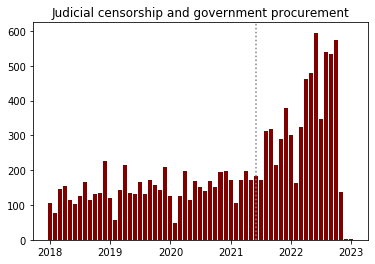

In [19]:
# df_procure = df_procure_copy.copy()
# # 1 -- for plaintiff, do they benefit from case censorship?
# df_temp = df_censor[['原告loc', '被告loc', '文书ID']]
# df_temp = df_temp.explode('原告loc')
# df_temp['原告'] = df_temp['原告loc'].apply(lambda x: x[0] if isinstance(x, list) else np.nan)
# procure_company_name = df_procure.ent_name.unique()
# df_temp['connected'] = df_temp.原告.isin(procure_company_name)
# # df_temp.connected.mean() == 0.044
# # Wrong date coding with < 20 entries
# df_procure = df_procure[df_procure.reporting_period < '2024']
# df_procure = df_procure[df_procure.reporting_period > '2018']
# df_procure = df_procure[df_procure.ent_name.isin(df_temp.原告.unique())]
# # df_firmyear is now a transaction / procurement level dataset 
# df_firmyear = df_procure.groupby(['ent_name', 'reporting_period1', 'reporting_period2']).id.count().reset_index()
# df_firmyear['yyyymm'] = df_firmyear.reporting_period1 + df_firmyear.reporting_period2
# df_firmyear.set_index('ent_name', inplace=True)
# # Ideally we want a panel dataset, as a balanced panel of all cross-products of firm*month
# df_balanced = df_firmyear.set_index('yyyymm', append=True).unstack().stack(dropna=False).reset_index()
# df_balanced['id'].fillna(0, inplace=True)
# del df_balanced['reporting_period1'], df_balanced['reporting_period2']
# df_balanced = df_balanced[(df_balanced.yyyymm > '2018')]
# df_balanced['total_transactions'] = df_balanced.groupby('ent_name').id.transform(sum)

# plt.figure()
# plt.title('Judicial censorship and government procurement')
# plt.bar(df_balanced.groupby('yyyymm').sum().reset_index().yyyymm, df_balanced.groupby('yyyymm').sum().reset_index().id, color='maroon')
# plt.axvline(x='202106', color='grey', ls=':')
# plt.xticks(['201801', '201901', '202001', '202101', '202201', '202301'], [2018, 2019, 2020, 2021, 2022, 2023])
# plt.show()

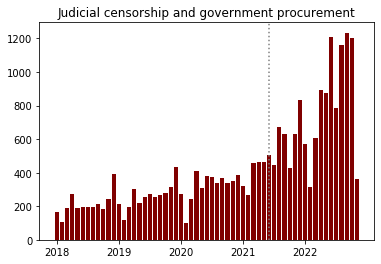

In [20]:
df_procure = df_procure_copy.copy()
# 2 -- for defendants, do they benefit from case censorship?
df_temp = df_censor[['原告loc', '被告loc', '文书ID']]
df_temp = df_temp.explode('被告loc')
df_temp['被告'] = df_temp['被告loc'].apply(lambda x: x[0] if isinstance(x, list) else np.nan)
procure_company_name = df_procure.ent_name.unique()
df_temp['connected'] = df_temp.被告.isin(procure_company_name)
# df_temp.connected.mean() == 0.044
# Wrong date coding with < 20 entries
df_procure = df_procure[df_procure.reporting_period < '2023']
df_procure = df_procure[df_procure.reporting_period > '2018']
df_procure = df_procure[df_procure.ent_name.isin(df_temp.被告.unique())]
# df_firmyear is now a transaction / procurement level dataset 
df_firmyear = df_procure.groupby(['ent_name', 'reporting_period1', 'reporting_period2']).id.count().reset_index()
df_firmyear['yyyymm'] = df_firmyear.reporting_period1 + df_firmyear.reporting_period2
df_firmyear.set_index('ent_name', inplace=True)
# Ideally we want a panel dataset, as a balanced panel of all cross-products of firm*month
df_balanced = df_firmyear.set_index('yyyymm', append=True).unstack().stack(dropna=False).reset_index()
df_balanced['id'].fillna(0, inplace=True)
del df_balanced['reporting_period1'], df_balanced['reporting_period2']
df_balanced = df_balanced[(df_balanced.yyyymm > '2018')]
df_balanced['total_transactions'] = df_balanced.groupby('ent_name').id.transform(sum)

plt.figure()
plt.title('Judicial censorship and government procurement')
plt.bar(df_balanced.groupby('yyyymm').sum().reset_index().yyyymm, df_balanced.groupby('yyyymm').sum().reset_index().id, color='maroon')
plt.axvline(x='202106', color='grey', ls=':')
plt.xticks(['201801', '201901', '202001', '202101', '202201'], [2018, 2019, 2020, 2021, 2022])
plt.show()

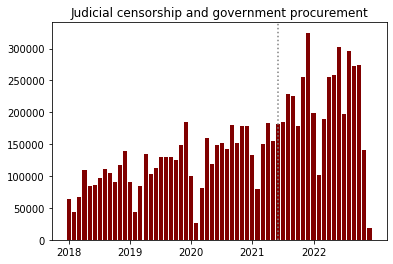

In [21]:
df_procure = df_procure_copy.copy()
# 3 -- what for the control group?
df_procure['yyyymm'] = df_procure['reporting_period1'] + df_procure['reporting_period2']
df_temp2 = df_procure.yyyymm.value_counts().reset_index()
df_temp2 = df_temp2[df_temp2['index'] > '2018']
df_temp2 = df_temp2[df_temp2['index'] < '2023']
df_temp2.sort_values('index', inplace=True)

# Plotting along the same line
plt.figure()
plt.title('Judicial censorship and government procurement')
plt.bar(df_temp2['index'], df_temp2.yyyymm, color='maroon')
plt.axvline(x='202106', color='grey', ls=':')
plt.xticks(['201801', '201901', '202001', '202101', '202201'], [2018, 2019, 2020, 2021, 2022])
plt.show()

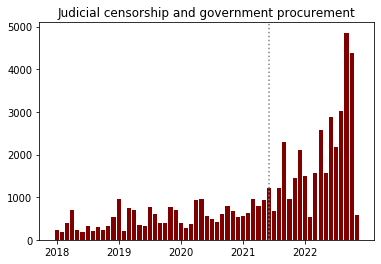

In [32]:
df_procure = df_procure_copy.copy()
# 4 -- not counting the # of government procurement, but instead counting the amount
# 4.2 defendant
df_temp = df_censor[['原告loc', '被告loc', '文书ID']]
df_temp = df_temp.explode('被告loc')
df_temp['被告'] = df_temp['被告loc'].apply(lambda x: x[0] if isinstance(x, list) else np.nan)
procure_company_name = df_procure.ent_name.unique()
df_temp['connected'] = df_temp.被告.isin(procure_company_name)
# df_temp.connected.mean() == 0.044
# Wrong date coding with < 20 entries
df_procure = df_procure[df_procure.reporting_period < '2023']
df_procure = df_procure[df_procure.reporting_period > '2018']
df_procure = df_procure[df_procure.ent_name.isin(df_temp.被告.unique())]
# df_firmyear is now a transaction / procurement level dataset 
df_firmyear = df_procure.groupby(['ent_name', 'reporting_period1', 'reporting_period2']).sales_amount.sum().reset_index()
df_firmyear['yyyymm'] = df_firmyear.reporting_period1 + df_firmyear.reporting_period2
df_firmyear.set_index('ent_name', inplace=True)
# Ideally we want a panel dataset, as a balanced panel of all cross-products of firm*month
df_balanced = df_firmyear.set_index('yyyymm', append=True).unstack().stack(dropna=False).reset_index()
df_balanced['sales_amount'].fillna(0, inplace=True)
del df_balanced['reporting_period1'], df_balanced['reporting_period2']
df_balanced = df_balanced[(df_balanced.yyyymm > '2018')]
df_balanced['total_transactions'] = df_balanced.groupby('ent_name').sales_amount.transform(sum)

plt.figure()
plt.title('Judicial censorship and government procurement')
plt.bar(df_balanced.groupby('yyyymm').sum().reset_index().yyyymm, df_balanced.groupby('yyyymm').mean().reset_index().sales_amount, color='maroon')
plt.axvline(x='202106', color='grey', ls=':')
plt.xticks(['201801', '201901', '202001', '202101', '202201'], [2018, 2019, 2020, 2021, 2022])
plt.show()

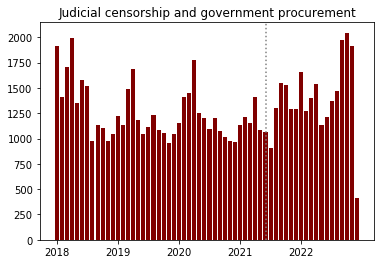

In [33]:
df_procure = df_procure_copy.copy()
# 3 -- what for the control group?
df_procure['yyyymm'] = df_procure['reporting_period1'] + df_procure['reporting_period2']
df_temp2 = df_procure.groupby('yyyymm').sales_amount.mean().reset_index()
df_temp2 = df_temp2[df_temp2['yyyymm'] > '2018']
df_temp2 = df_temp2[df_temp2['yyyymm'] < '2023']
df_temp2.sort_values('yyyymm', inplace=True)

# Plotting along the same line
plt.figure()
plt.title('Judicial censorship and government procurement')
plt.bar(df_temp2.yyyymm,df_temp2['sales_amount'], color='maroon')
plt.axvline(x='202106', color='grey', ls=':')
plt.xticks(['201801', '201901', '202001', '202101', '202201'], [2018, 2019, 2020, 2021, 2022])
plt.show()

In [7]:
# Analyis: firm-quarter level dataset with (1) outcome variable: # of govt procurement; (2) outcome variable: amount of procurement sales; (3) treatment indicator
df_procure = df_procure_copy.copy()

In [35]:
def month_to_quater(month):
    if month == '01' or month == '02' or month == '03':
        return 'Q1'
    if month == '04' or month == '05' or month == '06':
        return 'Q2'
    if month == '07' or month == '08' or month == '09':
        return 'Q3'
    if month == '10' or month == '11' or month == '12':
        return 'Q4'
df_procure['quarter'] = df_procure['reporting_period1'] + df_procure['reporting_period2'].apply(month_to_quater)

In [9]:
df_procure.columns

Index(['id', 'company_id', 'unified_code_x', 'state', 'create_time',
       'update_time', 'customer', 'sales_share', 'sales_amount',
       'reporting_period', 'data_sources', 'relationship', 'unified_code_y',
       'ent_name', 'reg_capital', 'industry', 'start_date', 'district',
       'district_code', '_merge', 'reporting_period1', 'reporting_period2',
       'reporting_period3', 'quarter'],
      dtype='object')

In [36]:
df_procure = df_procure[df_procure.reporting_period1 >= '2018']
df_procure['govt'] = df_procure.customer.apply(lambda x: isinstance(x, str) and (x.find('法院')!=-1 or x.find('检察院')!=-1 or x.find('政府')!=-1 or x.find('局')!=-1 or x.find('办公室')!=-1))
df_procure['company'] = df_procure.customer.apply(lambda x: isinstance(x, str) and x.find('公司')!=-1)
df_procure['state'] = 1
df_procure = df_procure[~df_procure.industry.isna()]
df_procure['district_code'] = df_procure['district_code'].apply(str)
df_procure_panel = df_procure.groupby(['ent_name', 'quarter']).agg(
    sales_amount = ('sales_amount', 'sum'),
    num = ('state', 'sum'),
    govt = ('govt', 'sum'),
    company = ('company', 'sum'),
    industry = ('industry', 'first'),
    district_code = ('district_code', 'max')
)
df_procure_panel = df_procure_panel.reset_index().sort_values(['ent_name', 'quarter'])

In [37]:
# Transform it into a balanced panel
df_procure_panel.set_index('ent_name', inplace=True)
df_balanced = df_procure_panel.set_index('quarter', append=True).unstack().stack(dropna=False).reset_index()
df_balanced[['sales_amount', 'num', 'govt', 'company']] = df_balanced[['sales_amount', 'num', 'govt', 'company']].fillna(0)
df_balanced['post'] = df_balanced.quarter.apply(lambda x: x>'2021Q1')
df_temp = df_censor[['原告loc', '被告loc', '文书ID']]
df_temp = df_temp.explode('被告loc')
df_temp['被告'] = df_temp['被告loc'].apply(lambda x: x[0] if isinstance(x, list) else np.nan)
df_balanced['treat'] = df_balanced['ent_name'].isin(df_temp.被告.unique())

# The reasonable comparison group is not the full sample, but the firms that goes onto a litigation, but not receiving the favor of censorship.
df_uncensor = pd.read_csv('/Users/kevin/Dropbox/legal_censorship/Data/master_uncensor.csv')
df_uncensor.原告loc = df_uncensor.原告loc.apply(literal_eval)
df_uncensor.被告loc = df_uncensor.被告loc.apply(literal_eval)

df_temp2 = df_uncensor[['原告loc', '被告loc']]
df_temp2 = df_temp2.explode('被告loc')
df_temp2['被告'] = df_temp2['被告loc'].apply(lambda x: x[0] if isinstance(x, list) else np.nan)
df_balanced = df_balanced[(df_balanced.ent_name.isin(df_temp2.被告.unique())) | df_balanced['ent_name'].isin(df_temp.被告.unique())]

df_balanced.to_csv(wd+'Data/procurement_firm_panel.csv', index=False)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# What's missing here: firms that do not receive any government procurement in the past 10 years.
